# <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Описание</div>

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо создать модель, которая предскажет температуру стали.

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Содержание</div>

****

1. [Загрузка и исследовательский анализ данных:](#load_and_data_analysis)
    1. [Загрузка библиотек](#load_libraries)
    2. [Импорт библиотек](#import_libraries)
    3. [Загрузка данных](#load_data)
    4. [Исследовательский анализ](#data_analysis)
    5. [Выводы по результатам анализа](#analysis_conclusions)
    
2. [Предобработка данных и обучение моделей](#preprocessing_and_model_training)
    1. [Удаление аномалий](#remove_outliers)
    2. [Генерация новых признаков](#feature_engineering)
    3. [Создание единого датафрейма](#merge_dataframes)
    4. [Обработка пропусков](#missing_values)
    5. [Проверка на мультиколлинеарность](#multicollinearity_check)
    6. [Подготовка выборок для обучения моделей](#data_preparation)
    7. [Выбор моделей](#model_selection)
    8. [Обучение моделей с определением лучшей (MAE)](#training_best_mae)
    9. [Проверка качества на тестовой выборке](#test_quality_check)
    10. [Анализ важности факторов (признаков)](#feature_importance_analysis)
    11. [Вывод](#preprocessing_conclusions)
    
3. [Отчет о проделанной работе](#project_report)

****

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="load_and_data_analysis"></a>Загрузка и исследовательский анализ данных</div>

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="load_libraries"></a>Загрузка библиотек</div>

Загрузим plotly для создания интерактивных графиков

In [ ]:
%pip install catboost
%pip install chart_studio python-igraph
%pip install lightgbm
%pip install plotly==5.11.0

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="import_libraries"></a>Импорт библиотек</div>

In [1]:
# импорт стандартных библиотек Python
import math
import warnings

# импорт сторонних библиотек
import chart_studio.plotly as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
#import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.api as sm
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import lognorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# установка отображения графиков в Jupyter Notebook
pio.renderers.default = 'notebook'

# константы
RANDOM_STATE = 100423

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="load_data"></a>Загрузка данных</div>

In [2]:
def load_dataframe(file_path, parse_dates=None):
    try:
        return pd.read_csv(file_path, parse_dates=parse_dates)
    except Exception as e:
        print(f"{file_path} - something went wrong: {e}")

# загрузка датасетов
try:
    data_arc = load_dataframe("/datasets/final_steel/data_arc.csv", 
                            parse_dates=["Начало нагрева дугой", "Конец нагрева дугой"])
    data_bulk = load_dataframe("/datasets/final_steel/data_bulk.csv")
    data_bulk_time = load_dataframe("/datasets/final_steel/data_bulk_time.csv",
                                parse_dates=[f"Bulk {i+1}" for i in range(15)])
    data_gas = load_dataframe("/datasets/final_steel/data_gas.csv")
    data_temp = load_dataframe("/datasets/final_steel/data_temp.csv", 
                             parse_dates=["Время замера"])
    data_wire = load_dataframe("/datasets/final_steel/data_wire.csv")
    data_wire_time = load_dataframe("/datasets/final_steel/data_wire_time.csv",
                                parse_dates=[f"Wire {i+1}" for i in range(9)])
except Exception as e:
    print("Something went wrong while loading the data:", e)

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="data_analysis"></a>Исследовательский анализ</div>

Данные загружены. Теперь напишем функцию для вывода информации о датасете.

In [3]:
def check_df(df):
    # Вывод сводной информации о датафрейме
    print("СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ")
    print("*" * 90)
    
    # Общая информация
    print(f"===ОБЩАЯ ИНФОРМАЦИЯ===\n{df.info()}")
    print("*" * 90)
    
    # 5 случайных строк датафрейма
    print(f"===5 СЛУЧАЙНЫХ СТРОК ДАТАФРЕЙМА===\n{df.sample(n=5)}")
    print("*" * 90)
    
    # Статистика
    print(f"===СТАТИСТИКА===\n{df.describe()}")
    print("*" * 90)
    
    # Количество дубликатов
    print(f"===КОЛИЧЕСТВО ДУБЛИКАТОВ===\n{df.duplicated().sum()}")
    print("*" * 90)
    
    # Пропущенные значения
    print(f"===ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ===\n{df.isna().sum()}")
    print("*" * 90)
    
    # Максимальное количество строк с одинаковым значением ключа
    print(f"===МАКСИМАЛЬНОЕ КОЛ-ВО СТРОК С ОДИНАКОВЫМ ЗНАЧЕНИМ KEY===\n{df['key'].value_counts().max()}")
    print("*" * 90)

И функцию создания графического представления нормального распределения

In [4]:
def show_qq(data):
    # вычисляем теоретические квантили для нормального распределения
    theoretical_quantiles = np.linspace(0, 1, len(data))
    theoretical_quantiles = np.quantile(
        np.random.normal(size=len(data)), theoretical_quantiles
    )

    # вычисляем эмпирические квантили для входных данных
    empirical_quantiles = np.quantile(data, np.linspace(0, 1, len(data)))

    # создаем график QQ-графика
    trace = go.Scatter(
        x=theoretical_quantiles,
        y=empirical_quantiles,
        mode="markers",
        marker=dict(color="blue"),
    )

    # добавляем диагональную линию на график
    min_value = min(theoretical_quantiles.min(), empirical_quantiles.min())
    max_value = max(theoretical_quantiles.max(), empirical_quantiles.max())
    diagonal_line = go.Scatter(
        x=[min_value, max_value],
        y=[min_value, max_value],
        mode="lines",
        line=dict(color="red", dash="dash"),
    )

    # создаем макет и фигуру
    layout = go.Layout(title="Q-Q график")
    fig = go.Figure(data=[trace, diagonal_line], layout=layout)
    fig.update_layout(
        title_x=0.5,
        showlegend=False,
        template="plotly_dark",
        width=800
    )

    # показываем график
    fig.show('png')

**Датасет, содержащий данные об электродах:**

In [5]:
check_df(data_arc)

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
===ОБЩАЯ ИНФОРМАЦИЯ===
None
******************************************************************************************
===5 СЛУЧАЙНЫХ СТРОК ДАТАФРЕЙМА===
        key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
7569   1646  2019-07-01 06:06:37 2019-07-01 06:08:13           

Наблюдается отрицательное минимальное значение признака `Реактивная мощность` - явный выброс.
Также максимальное кол-во строк с одинакомым `key` говорит о нескольких итерациях нагревания расплавленной стали. Посмотрим, как часто прибегают к этому.

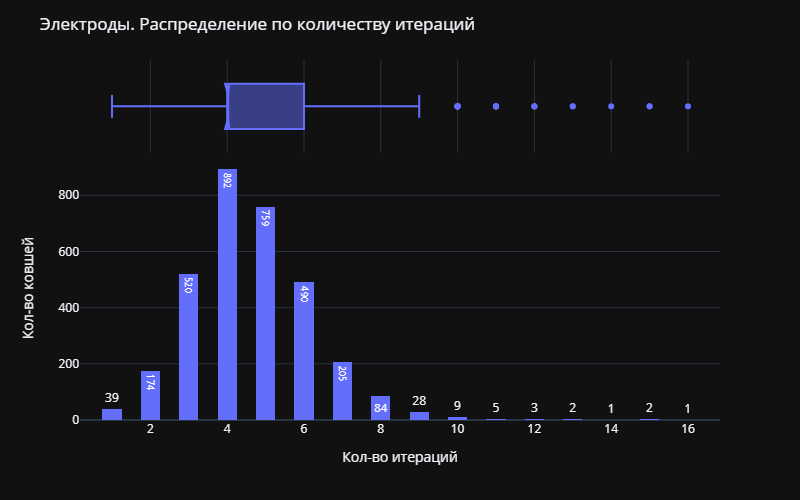

In [6]:
fig = px.histogram(
    data_arc.key.value_counts(),
    marginal="box",
    nbins=len(np.histogram_bin_edges(data_arc.key.value_counts(), bins="fd")),
    text_auto=True,
    width=800,
)
fig.update_layout(
    title="Электроды. Распределение по количеству итераций",
    xaxis_title="Кол-во итераций",
    yaxis_title="Кол-во ковшей",
    showlegend=False,
    template="plotly_dark",
)
fig.show("png")

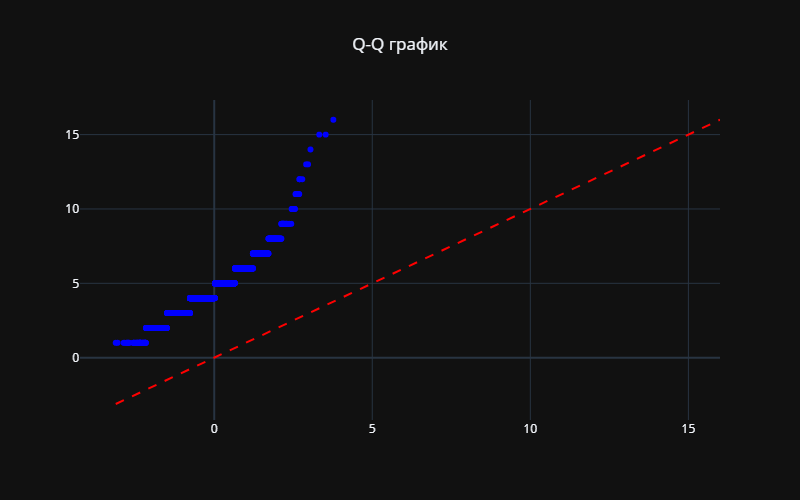

In [7]:
show_qq(np.array(data_arc.key.value_counts().values))

Сталь почти всегда доводят до нужной температуры больше 1 раза, но редко когда кол-во итераций превышает 10.

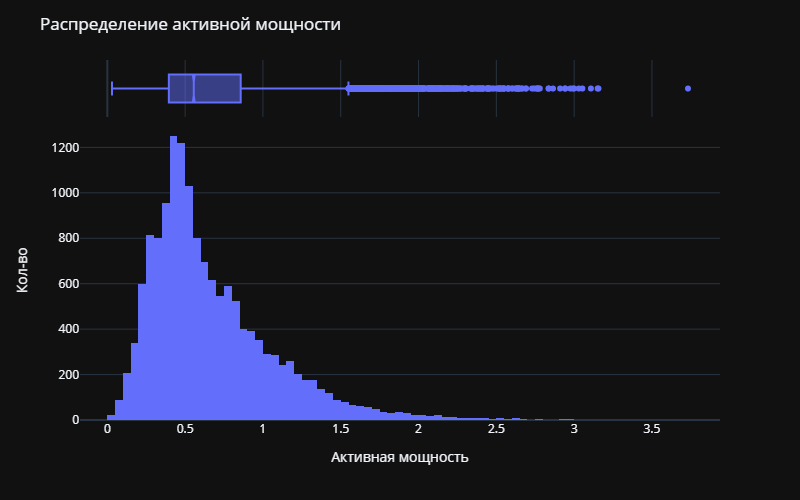

In [8]:
fig = px.histogram(
    data_arc,
    x="Активная мощность",
    marginal="box",
    nbins=len(np.histogram_bin_edges(data_arc["Активная мощность"], bins="fd")),
    width=800,
)
fig.update_layout(
    title="Распределение активной мощности",
    xaxis_title="Активная мощность",
    yaxis_title="Кол-во",
    showlegend=False,
    template="plotly_dark",
)
fig.show("png")

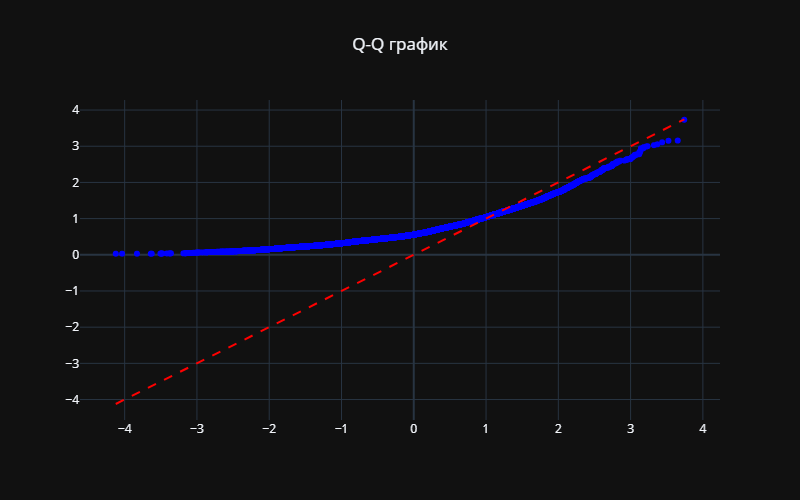

In [9]:
show_qq(data_arc["Активная мощность"])

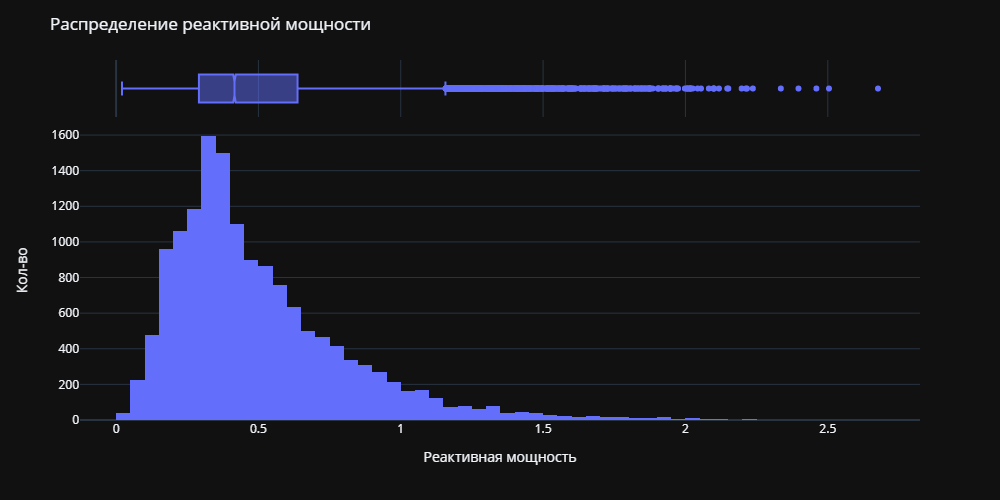

In [10]:
fig = px.histogram(
    data_arc[data_arc["Реактивная мощность"] >= 0],
    x="Реактивная мощность",
    marginal="box",
    nbins=len(
        np.histogram_bin_edges(
            data_arc[data_arc["Реактивная мощность"] >= 0]["Реактивная мощность"],
            bins="fd",
        )
    ),
    width=1000,
)
fig.update_layout(
    title="Распределение реактивной мощности",
    xaxis_title="Реактивная мощность",
    yaxis_title="Кол-во",
    showlegend=False,
    template="plotly_dark",
)
fig.show('png')

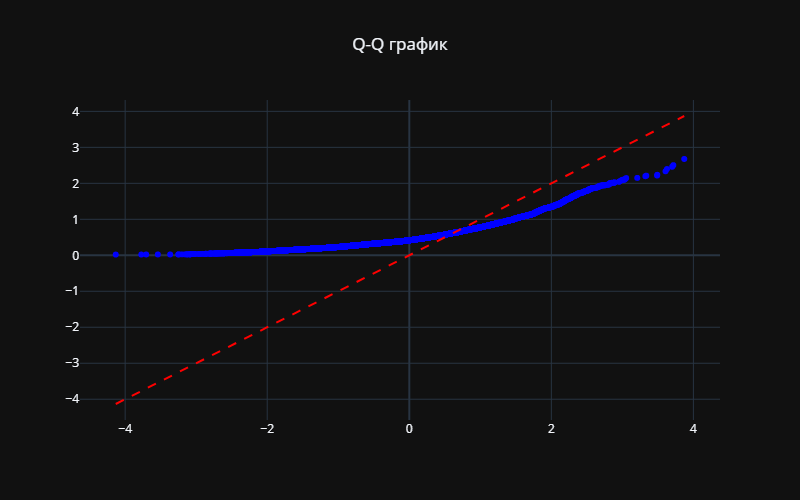

In [11]:
show_qq(data_arc.query("`Реактивная мощность` >= 0")["Реактивная мощность"])

Все графики скошены вправо. О нормальном распределении говорить не приходится. Пропусков нет. При создании гистограммы по распределению реактивной мощности был отфильтрован явный выброс с отрицательным значением мощности.

**Датасет, содержащий данные о подаче сыпучих материалов (объём):**

In [12]:
check_df(data_bulk)

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
===ОБЩАЯ ИНФОРМАЦИЯ===
None
*****

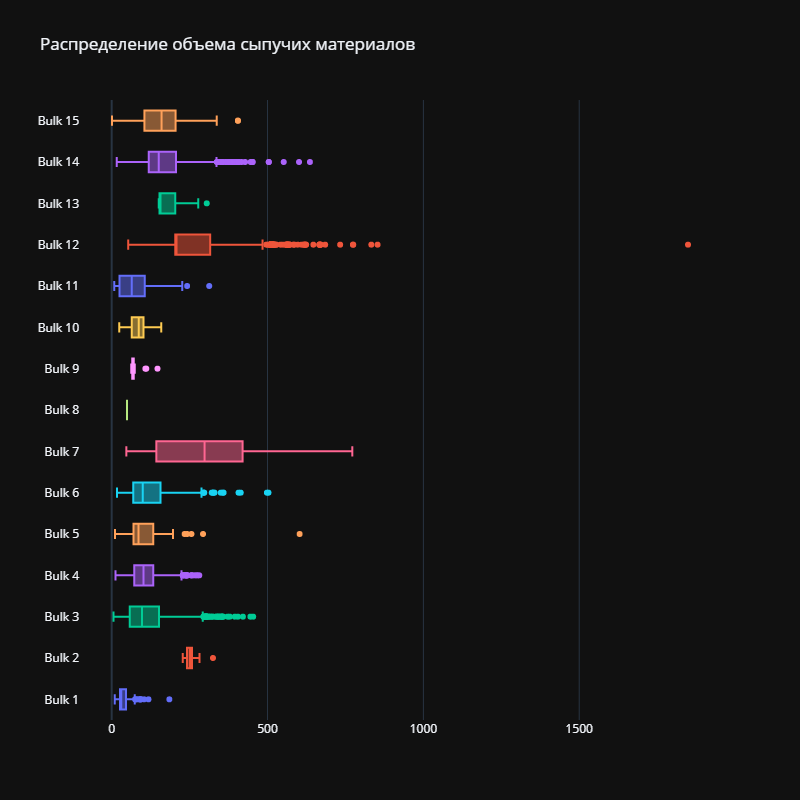

In [13]:
fig = make_subplots()

for i in range(15):
    fig.add_trace(go.Box(x=data_bulk[f"Bulk {i+1}"], name=f"Bulk {i+1}"))

fig.update_layout(
    title_text="Распределение объема сыпучих материалов",
    height=800,
    width=800,
    showlegend=False,
    template='plotly_dark',
)
fig.show('png')

Наблюдается огромное количество пропусков. Так, легирующая добавка под номером 8 вообще использовалась всего один раз. В то время, как 14-й элемент используется наиболее часто. Скорее всего, это не пропуски, а потенциальные нули.
Каждая запись датафрейма представляет один "ковш", следовательно в нем указан общий объем легирующих элементов.

**Датасет, содержащий данные о подаче сыпучих материалов (время):**

In [14]:
check_df(data_bulk_time)

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  

Поличество пропусков соответствует количеству пропусков в предыдущем датасете, что утверждает во мнении, что это не потерянные данные, а особенность записи. 

**Датасет, содержащий данные о продувке сплава газом:**

In [15]:
check_df(data_gas)

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
===ОБЩАЯ ИНФОРМАЦИЯ===
None
******************************************************************************************
===5 СЛУЧАЙНЫХ СТРОК ДАТАФРЕЙМА===
       key     Газ 1
1313  1316  8.042956
2355  2358  6.758468
2084  2087  7.449362
842    845  5.884646
2282  2285  9.728302
******************************************************************************************
===СТАТИСТИКА===
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7

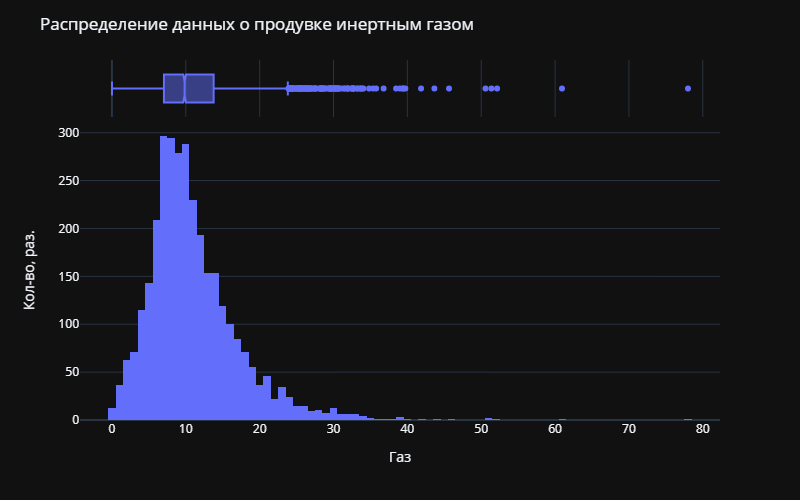

In [16]:
fig = px.histogram(
    data_gas,
    x="Газ 1",
    marginal="box",
    nbins=len(np.histogram_bin_edges(data_gas["Газ 1"], bins="fd")),
)
fig.update_layout(
    title="Распределение данных о продувке инертным газом",
    xaxis_title="Газ",
    yaxis_title="Кол-во, раз.",
    showlegend=False,
    template='plotly_dark',
    width=800,
)
fig.show('png')

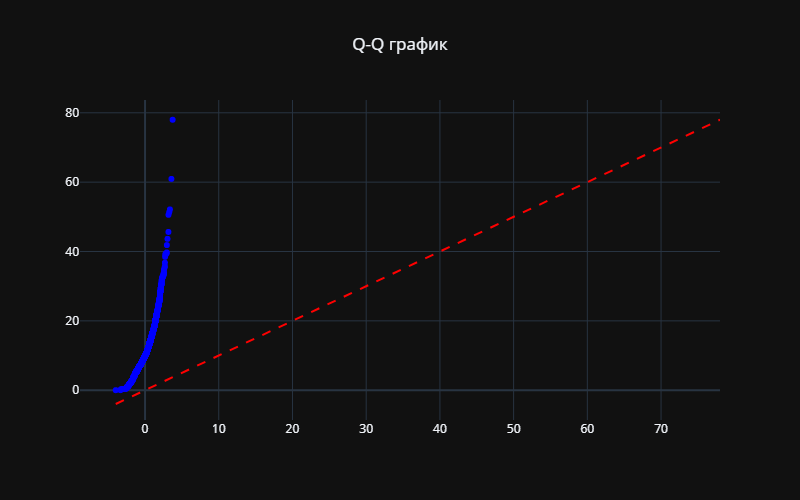

In [17]:
show_qq(data_gas['Газ 1'])

Пропусков нет. Каждая запись соответсвует одному "ковшу". Все тот же скос вправо, все также далеко от нормального распределения.

**Датасет, содержащий данные о результатах измерения температуры:**

In [18]:
check_df(data_temp)

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB
===ОБЩАЯ ИНФОРМАЦИЯ===
None
******************************************************************************************
===5 СЛУЧАЙНЫХ СТРОК ДАТАФРЕЙМА===
        key        Время замера  Температура
5453   1096 2019-06-12 11:14:31       1583.0
1136    202 2019-05-10 19:42:05       1605.0
7827   1592 2019-06-29 14:43:26       1614.0
5847   1187 2019-06-15 10:07:02       1625.0
15602  3171 2019-08-29 20:36:57          NaN
************************

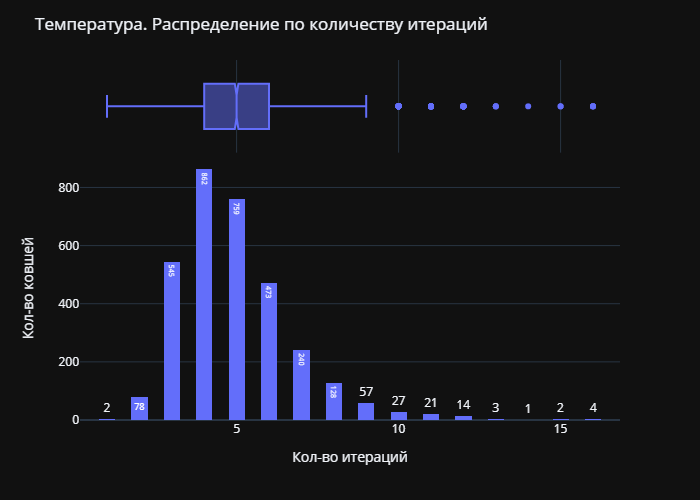

In [19]:
fig = px.histogram(
    data_temp.key.value_counts(),
    marginal="box",
    nbins=len(np.histogram_bin_edges(data_temp.key.value_counts(), bins="fd")),
    text_auto=True,
)
fig.update_layout(
    title="Температура. Распределение по количеству итераций",
    xaxis_title="Кол-во итераций",
    yaxis_title="Кол-во ковшей",
    showlegend=False,
    template="plotly_dark",
)
fig.show('png')

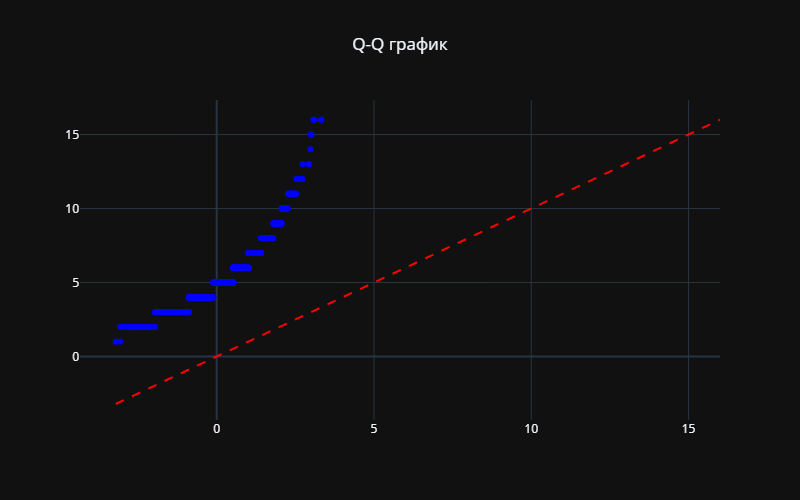

In [20]:
show_qq(data_temp.key.value_counts())

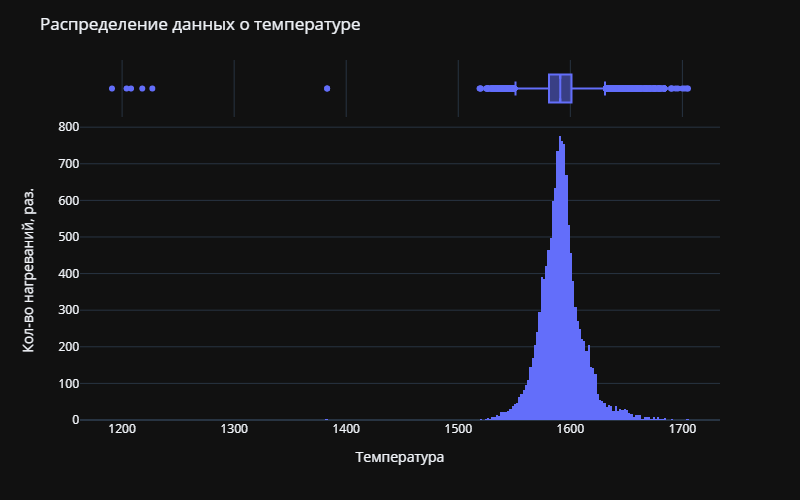

In [21]:
fig = px.histogram(
    data_temp,
    x="Температура",
    marginal="box",
    nbins=len(np.histogram_bin_edges(data_temp["Температура"].dropna(), bins="fd")),
)
fig.update_layout(
    title="Распределение данных о температуре",
    xaxis_title="Температура",
    yaxis_title="Кол-во нагреваний, раз.",
    showlegend=False,
    template="plotly_dark",
    width=800,
)
fig.show('png')

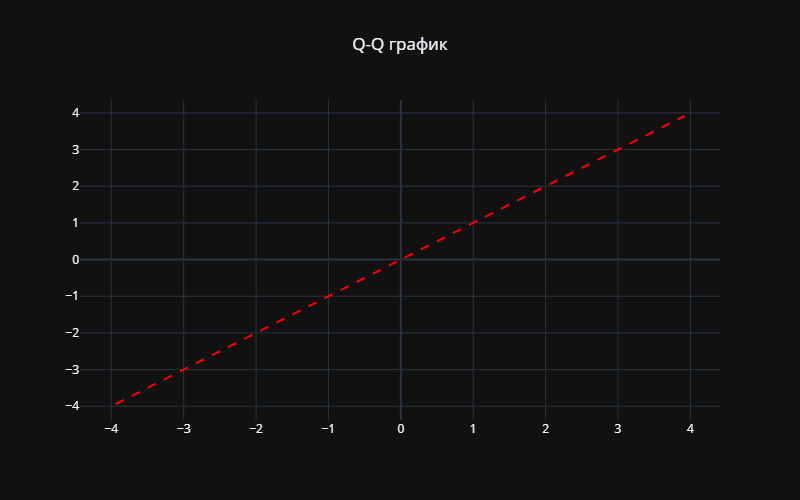

In [22]:
show_qq(data_temp['Температура'])

Данные о темературе перекликаются с данными об электодах в части распределения по количеству итераций, что вполне себе закономерно.
Из гистограммы о распределении данных о температуре можно сделать вывод, что чаще всего отливается тугоплавкая сталь, о чем свидетельствует температура в районе 1600 &deg;C

**Датасет, содержащий данные о проволочных материалах (объём):**

In [23]:
check_df(data_wire)

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
===ОБЩАЯ ИНФОРМАЦИЯ===
None
******************************************************************************************
===5 СЛУЧАЙНЫХ СТРОК ДАТАФРЕЙМА===
       key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
1909  2003  104.919356        NaN     NaN  

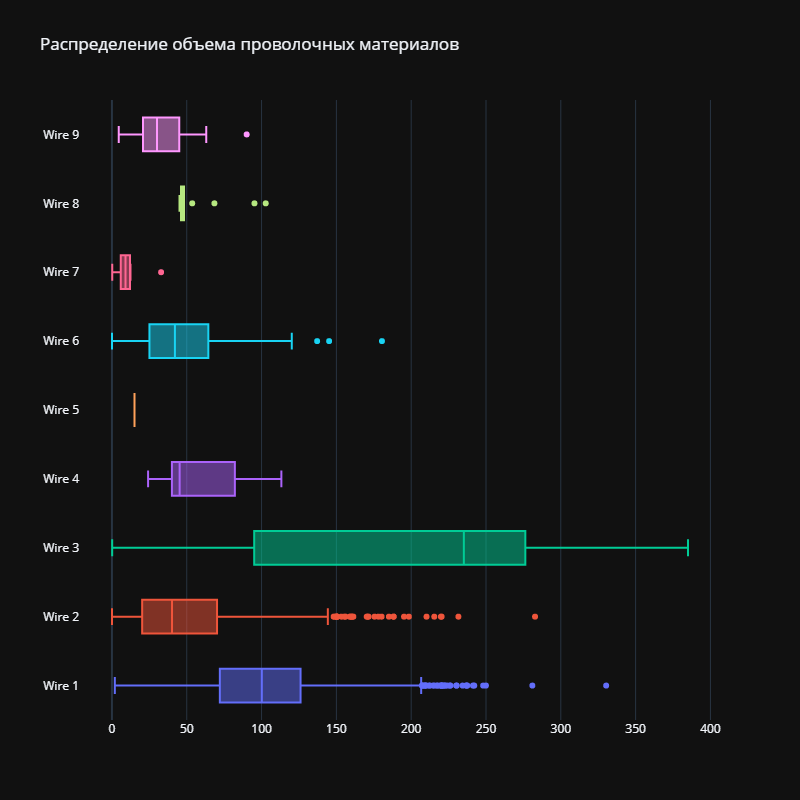

In [24]:
fig = make_subplots()

for i in range(9):
    fig.add_trace(go.Box(x=data_wire[f"Wire {i+1}"], name=f"Wire {i+1}"))

fig.update_layout(
    title_text="Распределение объема проволочных материалов",
    height=800,
    width=800,
    showlegend=False,
    template="plotly_dark",
)
fig.show("png")

Как и в случае с сыпучими материалами, мы наблюдаем большое количество пропусков данных, которые на самом деле являются нулями, т.е. не были использованы при легировании стали в конкретном ковше. Так, 5-й элемент использовался лишь однажды, в то время как 3-й добавляется в сталь чаще остальных.

**Загрузим датасет, содержащий данные о проволочных материалах (время):**

In [25]:
check_df(data_wire_time)

СВОДНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ
******************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
===ОБЩАЯ ИНФОРМАЦИЯ===
None
******************************************************************************************
===5 СЛУЧАЙНЫХ СТРОК ДАТАФРЕЙМА===
       key              Wire 

Пропуски целиком совпадают с пропусками в предыдущем датасете. 

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="analysis_conclusions"></a>Выводы по резутатам анализа</div>

Загрузив данные и проведя исследовательский анализ данных, можно сделать следущие выводы:

1. Названия признаков в исследуемых датасетах не приведены к общему виду - необходимо будет это исправить на этапе предобработки данных;
1. Типы данных признаков не везде соответствуют реально хранащимся в них данных. Например, в датасете `data_bulk` целочисленные данные хранятся в виде дробных - исправим на этапе предобработки;
1. Типы данных излишне "тяжелые". Например, хранить `key` в int64 - непозволительная роскошь и дополнительная нагрузка на вычислительные мощности. На этапе предобработки исправим;
1. Целевым признаком определим последний замер температуры для каждого ковша - `data_temp['Температура']`;
1. Пропуски в датасетах `data_bulk`, `data_bulk_time`, `data_wire`, `data_wire_time` с большей долей вероятности связаны с особенностью записи данных и фактически является не пропусками, а нулевыми значениями. Заполним нулями на этапе предобработки.
1. Датасеты содержащие данные о времени `data_bulk_time` и `data_wire_time` не представляют интереса для задачи текущего исследования. Вероятно придется от них отказаться за ненадобностью.
1. Работа с множеством датасетов будет неудобной, поэтому объединим им по признаку `key` в единый датасет.

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="preprocessing_and_model_training"></a>Предобработка данных и обучение моделей</div>

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="remove_outliers"></a>Удаление аномалий</div>

**Исправление названий признаков**

Переименуем названия признаков и приведем их к змеиному регистру

In [26]:
data_arc.columns = ["key", "heating_start_time", "heating_end_time", "active_power", "reactive_power"]

data_bulk.rename(
    columns={f"Bulk {i+1}": f"bulk_{i+1}" for i in range(15)}, inplace=True
)

data_bulk_time.rename(
    columns={f"Bulk {i+1}": f"bulk_{i+1}" for i in range(15)}, inplace=True
)

data_gas.columns = ["key", "gas"]

data_temp.columns = ["key", "measurement_time", "temperature"]

data_wire.rename(columns={f"Wire {i+1}": f"wire_{i+1}" for i in range(9)}, inplace=True)

data_wire_time.rename(
    columns={f"Wire {i+1}": f"wire_{i+1}" for i in range(9)}, inplace=True
)

**Удаление явных выбросов**

В `data_arc` есть явный выброс с отрицательной реактивной мощностью. Удалим всю партию.

In [27]:
data_arc.query(
    f'key != {data_arc.query("reactive_power < 0")["key"].values[0]}', inplace=True
)

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="feature_engineering"></a>Генерация новых признаков</div>

Добавим в data_arc новый признак - `full_power`, который рассчитаем по формуле:
$$
S = \sqrt{P^2+Q^2}
$$
Для упрощения процесса создадим функцию:

In [28]:
def full_power_calc(row):
    return np.sqrt(np.square(row["active_power"]) + np.square(row["reactive_power"]))

И применим ее:

In [29]:
data_arc["full_power"] = data_arc.apply(full_power_calc, axis=1)

Создадим признак, содержащий количество итераций в каждой партии:

In [30]:
iteration_count = data_arc.groupby(by="key", as_index=False).count()[
    ["key", "heating_start_time"]
]
iteration_count.columns = ["key", "iteration_count"]

Объединим таблицы `data_arc` и `iteration_count`, дропнув при этом показатели активной и реактивной мощности:

In [31]:
data_arc = (
    data_arc.groupby(by="key", as_index=False)
    .sum()
    .merge(iteration_count, how="left", on="key")
    .drop(columns=["active_power", "reactive_power"], axis=1)
)

Дропнем пропуски в замерах температуры:

In [32]:
data_temp = (
    data_temp.dropna(subset=["temperature"])
    .reset_index(drop=True)
    .sort_values(by=["measurement_time"])
)

Создадим список с номерами партий, содержащих только один замер температуры:

In [33]:
single_measurement_list = (
    data_temp.groupby(by="key", as_index=False)
    .count()[
        data_temp.groupby(by="key", as_index=False).count()["measurement_time"] == 1
    ]["key"]
    .tolist()
)

data_temp.query("key not in @single_measurement_list", inplace=True)

Группируем данные по первому и последнему замеру температуры

In [34]:
data_temp = data_temp.groupby(by="key").agg(["first", "last"]).reset_index()
data_temp.columns = data_temp.columns.droplevel()

Переименовываем названия признаков и дропаем призаки содержащие время замера

In [35]:
data_temp.columns = [
    "key",
    "measurement_time_1",
    "measurement_time_2",
    "temperature_first",
    "temperature_last",
]
data_temp.drop(["measurement_time_1", "measurement_time_2"], axis=1, inplace=True)

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="merge_dataframes"></a>Создание единого датафрейма</div>

Объеденим преобразованные таблицы по номеру партии:

In [36]:
data = (
    data_temp.merge(data_arc, how="inner", on="key")
    .merge(data_wire, how="inner", on="key")
    .merge(data_bulk, how="inner", on="key")
    .merge(data_gas, how="inner", on="key")
)

In [37]:
data.sample(n=10)

,key,temperature_first,temperature_last,full_power,iteration_count,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas
1488,1596,1594.0,1580.0,3.514048,5,126.874810,108.153756,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,156.0,NaN,153.0,104.0,18.670852
197,226,1585.0,1586.0,4.407895,4,74.212326,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,205.0,NaN,163.0,205.0,9.770296
1749,1871,1615.0,1596.0,4.748304,5,160.149598,20.116720,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,461.0,NaN,198.0,209.0,14.935716
1574,1685,1574.0,1589.0,3.815720,6,147.092407,142.958401,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,NaN,7.740282
373,417,1575.0,1585.0,4.972696,6,130.291199,50.095760,260.131897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178.0,NaN,26.024810
1176,1267,1572.0,1606.0,5.923949,5,87.141602,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,54.0,NaN,205.0,NaN,207.0,204.0,7.119604
2304,2475,1597.0,1594.0,3.523479,4,137.155197,18.096000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,361.0,NaN,126.0,205.0,9.613378
2250,2415,1569.0,1586.0,3.006600,3,47.087040,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,226.0,NaN,114.0,106.0,5.444091
861,936,1581.0,1595.0,3.685517,6,149.759991,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,512.0,NaN,249.0,103.0,6.815111
1819,1942,1585.0,1611.0,8.265084,7,68.053436,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,360.0,NaN,160.0,212.0,6.473175


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="missing_values"></a>Обработка пропусков</div>

И заполним пропуски нулями.

In [38]:
data.fillna(0, inplace=True)

Посмотрим на результат наших стараний:

In [39]:
data.sample(n=15)

,key,temperature_first,temperature_last,full_power,iteration_count,wire_1,wire_2,wire_3,wire_4,wire_5,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas
8,9,1587.0,1592.0,2.555348,5,113.393279,9.143681,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623
2179,2330,1602.0,1598.0,2.285467,4,186.295197,23.494640,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,106.0,0.0,126.0,102.0,15.069737
191,219,1596.0,1588.0,3.470795,6,103.215836,12.084800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,107.0,203.0,15.214940
1335,1432,1553.0,1589.0,4.569753,8,100.058403,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,215.0,0.0,102.0,104.0,10.710357
1581,1692,1568.0,1591.0,4.321535,4,130.103989,89.424392,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,91.0,185.0,0.0,129.0,107.0,8.475505
5,6,1543.0,1596.0,4.786837,4,99.109917,9.114560,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392
699,759,1602.0,1620.0,6.594938,7,101.275200,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,76.0,0.0,368.0,0.0,225.0,189.0,12.421341
1347,1445,1611.0,1619.0,4.604480,4,154.065598,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,254.0,0.0,129.0,205.0,12.872610
1507,1615,1586.0,1574.0,0.806438,1,24.055201,10.163919,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,320.0,0.0,6.645187
2248,2413,1598.0,1594.0,1.255614,2,107.015999,15.230800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.244847


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="multicollinearity_check"></a>Проверка на мультиколлинеарность</div>

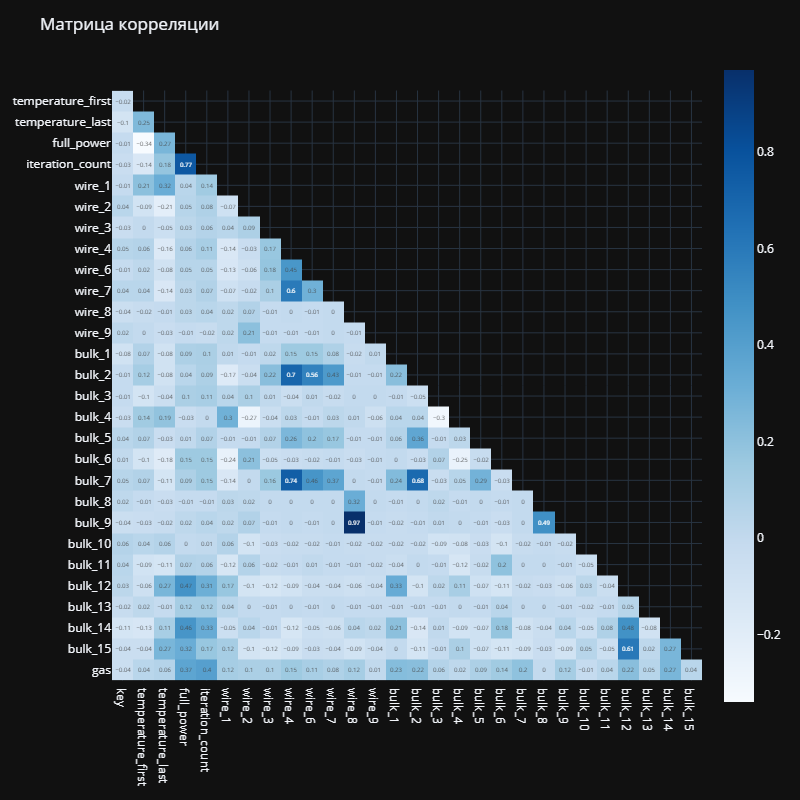

In [40]:
# Создаем матрицу корреляции на основе данных
df_corr = data.corr().round(2)

# Создаем маску для верхнего треугольника матрицы (чтобы избежать дублирования значений)
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Применяем маску к матрице корреляции и удаляем пустые строки и столбцы визуализируемой матрицы
df_corr_viz = df_corr.mask(mask).dropna(how="all").dropna("columns", how="all")

# Визуализируем матрицу с помощью библиотеки plotly в формате png и задаем ее параметры
fig = px.imshow(
    df_corr_viz,
    text_auto=True,
    width=800,
    height=800,
    color_continuous_scale=px.colors.sequential.Blues,
)
fig.update_layout(title="Матрица корреляции", showlegend=False, template="plotly_dark")
fig.show("png")

Выберем наиболее коррелирующие признаки:

In [41]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    return xFiltered.unstack().sort_values().drop_duplicates()


corrFilter(data, .7)

wire_4      bulk_7             0.740572
full_power  iteration_count    0.765804
wire_8      bulk_9             0.974969
key         key                     NaN
dtype: float64

Итак, коррелируют между собой признаки две пары сыпучих и проволочных материалов, а так же показатель полной мощности и количества итераций в партии. Что касается пар материалов, вероятно это связано с технологическим процессом и при добавлении конкретного сыпучено материала требуется добавление соответствующего проволочного, и такая явная зависимость существует только у двух пар материалов, причем у одной из них wire_8/bulk_9 эта зависимость практически равна единице. Зависимость же между полной мощностью и количеством итераций очевидна, т.к. каждая итерация подразумевает нагревание стали, а следовательно и расход энергии.

Мультиколлинеарность небольшая, но все-таки присутствует, что не очень хорошо может отразиться на качестве линейной модели, однако регурялизация признаков перед обучением позволит сгладить этот момент.

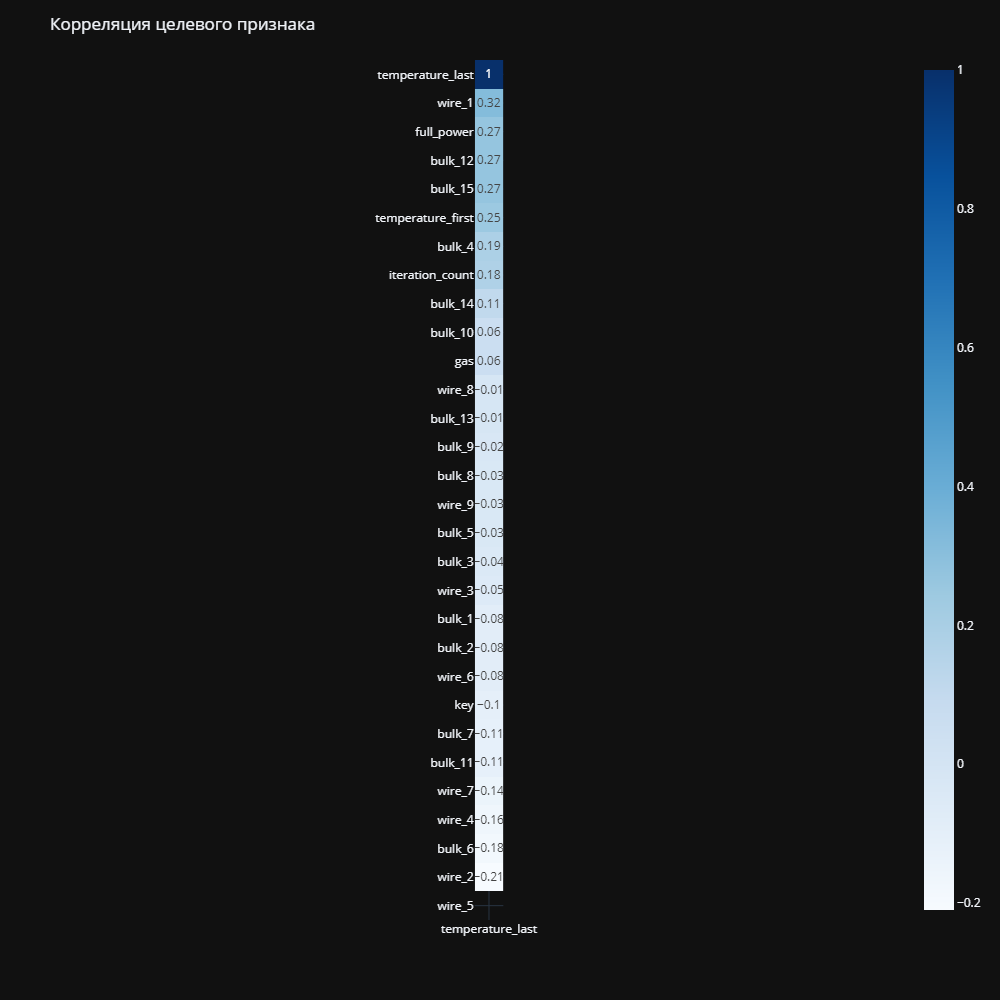

In [42]:
fig = px.imshow(
    round(
        data.corr()[["temperature_last"]].sort_values(
            by="temperature_last", ascending=False
        ),
        2,
    ),
    text_auto=True,

    color_continuous_scale=px.colors.sequential.Blues,
)
fig.update_layout(
    title="Корреляция целевого признака", showlegend=False, template="plotly_dark",
    height=1000,
    width=1000,
)
fig.show("png")

Пятый вид проволочных материалов оказался пустым. Не очень хорошо, конечно, но что имеем. Удалим его и `key`, чтобы не мешался.

In [43]:
data.drop(["wire_5", 'key'], axis=1, inplace=True)

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="data_preparation"></a>Подготовка выборок для обучения моделей</div>

In [44]:
features = data.drop(["temperature_last"], axis=1)
target = data["temperature_last"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [46]:
print(f'{"-"*40}\n{"Размеры выборок":^40}\n{"-"*40}')
print(f'{"Обучающая выборка:":<25}{X_train.shape[0]:>15}')
print(f'{"Тестовая выборка:":<25}{X_test.shape[0]:>15}')
print("-"*40)

----------------------------------------
            Размеры выборок             
----------------------------------------
Обучающая выборка:                  1746
Тестовая выборка:                    582
----------------------------------------


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="model_selection"></a>Выбор моделей</div>

В рамках текущего исследования выберем для обучения 4 модели:

- Модель линейной регрессии - Ridge (Гребневая регрессия)
- "Деревянная" модель - RandomForestRegressor (Модель случайного леса)

и две модели градиентного бустинга:

- Модель градиентного бустинга от Яндекса - CatBoostRegressor
- Модель градиентного бустинга от ~~мелкомягких~~ Microsoft - LightGBMRegressor

Приступим к обучению по порядку:


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="training_best_mae"></a>Обучение моделей с определением лучшей (MAE)</div>

#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">Ridge</div>

Помятуя о том, что в данных у нас наблюдается мультиколлинерность, будем подбирать гиперпараметр регурялизации с использованием Pipeline и GridSearchCV.

In [47]:
%%time

# random_state не перебирается, задаём его прямо в модели
model_ridge = Ridge(random_state=RANDOM_STATE)

# создаем pipeline для стандартизации данных и регрессии Ridge
pipe_ridge = Pipeline([('std_scaler', StandardScaler()), ('ridge', Ridge())])

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'ridge__alpha': np.logspace(-1, 1, 10)
}

# Создаем объект поиска по сетке с перекрестной проверкой
ridge = GridSearchCV(
    pipe_ridge, 
    param_grid_ridge, 
    scoring='neg_mean_absolute_error', 
    verbose=3,
    n_jobs=-1, # Используем все доступные ядра процессора
    cv=5 # Количество блоков для перекрестной проверки
)

# Обучаем модель Ridge на тренировочных данных
ridge.fit(X_train, y_train)

# Получаем параметры лучшей модели и её оценку
ridge_best_params = ridge.best_params_
ridge_best_score = abs(ridge.best_score_)

# Выводим результаты обучения
print('------------------------------')
print(f"best_params: {ridge_best_params}")
print(f"best_score: {ridge_best_score}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
------------------------------
best_params: {'ridge__alpha': 10.0}
best_score: 6.26827868210322
CPU times: total: 141 ms
Wall time: 5.17 s


Весьма достойный покзатель. Попали в целевое значение метрики.

#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">RandomForestRegressor</div>

In [48]:
%%time

# Создаем объект модели случайного леса с заданным random_state
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

# Задаем сетку параметров для случайного леса
param_grid_rf = {
    "n_estimators": range(50, 701, 50),
    'criterion':['absolute_error']
}

# Создаем объект случайного поиска с перекрестной проверкой
rf = RandomizedSearchCV(
    model_rf,
    param_grid_rf,
    scoring="neg_mean_absolute_error",
    n_jobs=-1, # Используем все доступные ядра процессора
    cv=5 # Количество блоков для перекрестной проверки
)

# Обучаем модель случайного леса на тренировочных данных
rf.fit(X_train, y_train)

# Находим лучшие гиперпараметры и лучшую метрику на кросс-валидации
rf_best_params = rf.best_params_
rf_best_score = abs(rf.best_score_)

# Выводим результаты обучения
print("------------------------------")
print(f"best_params: {rf_best_params}")
print(f"best_score: {rf_best_score}")

------------------------------
best_params: {'n_estimators': 150, 'criterion': 'absolute_error'}
best_score: 6.1032639541547296
CPU times: total: 15.6 s
Wall time: 3min 52s


"Дереянная" модель дольше обучается, но тоже показывает хорошее значение метрики.

#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">CatBoostRegressor</div>

In [49]:
%%time

# Создаем модель CatBoostRegressor
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE)

# Задаем сетку параметров для поиска лучшей комбинации гиперпараметров
param_grid_cbr = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 1000]
}

# Создаем объект GridSearchCV для поиска лучших гиперпараметров
cbr = GridSearchCV(
    model_cbr,
    param_grid_cbr,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=5
)

# Обучаем модель на тренировочных данных
cbr.fit(X_train, y_train)

# Находим лучшие гиперпараметры и лучшую метрику на кросс-валидации
cbr_best_params = cbr.best_params_
cbr_best_score = abs(cbr.best_score_)

# Выводим результаты
print("------------------------------")
print(f"best_params: {cbr_best_params}")
print(f"best_score: {cbr_best_score}")


0:	learn: 11.1980967	total: 54.8ms	remaining: 54.8s
1:	learn: 11.1653134	total: 56.2ms	remaining: 28s
2:	learn: 11.1347522	total: 57.5ms	remaining: 19.1s
3:	learn: 11.1047978	total: 58.7ms	remaining: 14.6s
4:	learn: 11.0758755	total: 60.2ms	remaining: 12s
5:	learn: 11.0464570	total: 61.6ms	remaining: 10.2s
6:	learn: 11.0228352	total: 63.3ms	remaining: 8.98s
7:	learn: 11.0029859	total: 64.6ms	remaining: 8.01s
8:	learn: 10.9777097	total: 65.9ms	remaining: 7.26s
9:	learn: 10.9519480	total: 67.6ms	remaining: 6.69s
10:	learn: 10.9286982	total: 69.1ms	remaining: 6.21s
11:	learn: 10.9006866	total: 70.4ms	remaining: 5.79s
12:	learn: 10.8740825	total: 71.7ms	remaining: 5.44s
13:	learn: 10.8472139	total: 73.1ms	remaining: 5.15s
14:	learn: 10.8182198	total: 74.4ms	remaining: 4.88s
15:	learn: 10.7889390	total: 75.6ms	remaining: 4.65s
16:	learn: 10.7630542	total: 77.1ms	remaining: 4.46s
17:	learn: 10.7353497	total: 78.9ms	remaining: 4.3s
18:	learn: 10.7150715	total: 80.1ms	remaining: 4.14s
19:	lear

С каждой моделью метрика все лучше и лучше.

#### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto">LGBMRegressor</div>

In [50]:
%%time

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
param_grid_lgbm = {
    "num_leaves": range(4, 31),
    "learning_rate": [0.03, 0.06, 0.09]
}
lgbm = RandomizedSearchCV(
    model_lgbm,
    param_distributions=param_grid_lgbm,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=5
)
lgbm.fit(X_train, y_train)

lgbm_best_params = lgbm.best_params_
lgbm_best_score = abs(lgbm.best_score_)

print("------------------------------")
print(f"best_params: {lgbm_best_params}")
print(f"best_score: {lgbm_best_score}")

------------------------------
best_params: {'num_leaves': 29, 'learning_rate': 0.03}
best_score: 6.059701103766259
CPU times: total: 703 ms
Wall time: 788 ms


LGBM учится гораздо быстрее "кошачьей модели", но демонстрирует метрику чуть хуже.

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="model_selection"></a>Выбор лучшей модели</div>

In [51]:
# Создаем DataFrame
result_grid = pd.DataFrame()

# Добавляем значения
result_grid.loc['Ridge', 'MAE'] = ridge_best_score
result_grid.loc['RandomForestRegressor', 'MAE'] = rf_best_score
result_grid.loc['CatBoostRegressor', 'MAE'] = cbr_best_score
result_grid.loc['LightGBM', 'MAE'] = lgbm_best_score

# Определяем функцию, которая будет определять стиль ячейки
def highlight_min(s):
    '''
    Выделяет минимальное значение зеленым
    '''
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

# Применяем функцию к DataFrame и выводим результат
result_grid.style.apply(highlight_min)

,MAE
Ridge,6.268279
RandomForestRegressor,6.103264
CatBoostRegressor,5.939180
LightGBM,6.059701


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="test_quality_check"></a>Проверка качества лучшей модели на тестовой выборке</div>

In [52]:
# делаем предсказания на тестовых данных
cbr_prediction = cbr.predict(X_test)

# вычисляем MAE на тестовых данных
cbr_mae_test = mean_absolute_error(y_test, cbr_prediction)

# выводим результаты
print("Качество метрики MAE на тестовой выборке: {0:.4f}".format(cbr_mae_test))

Качество метрики MAE на тестовой выборке: 6.0376


### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="feature_importance_analysis"></a>Анализ важности факторов (признаков)</div>

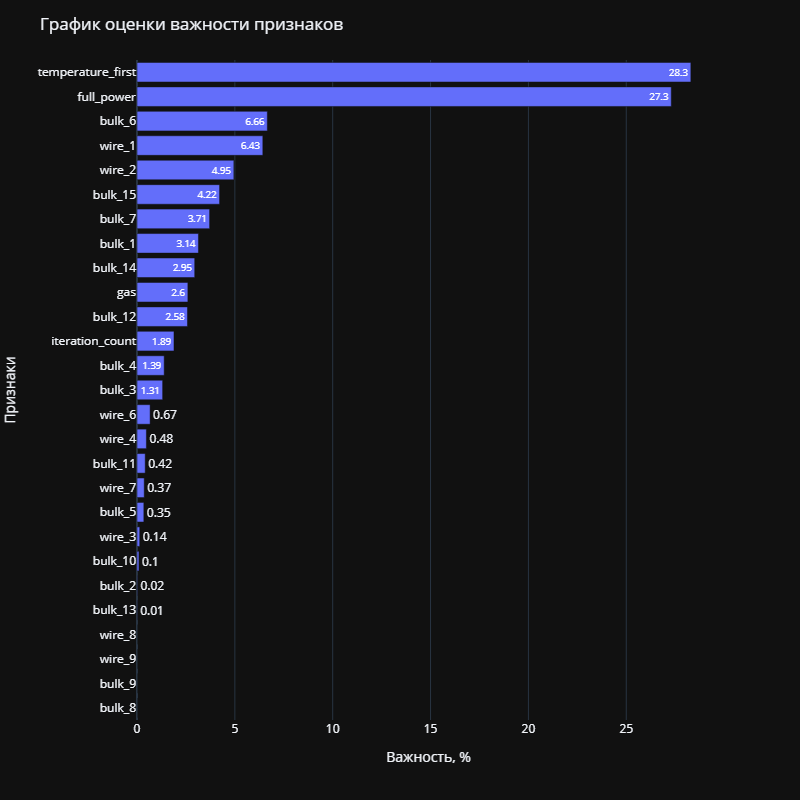

In [53]:
# создаем график
fig = px.bar(
    pd.Series(
        np.round(cbr.best_estimator_.feature_importances_, 2), index=X_test.columns
    ).sort_values(ascending=True),
    orientation="h",
    text_auto=True,
)

# настраиваем параметры графика
fig.update_layout(
    title="График оценки важности признаков",
    xaxis_title="Важность, %",
    yaxis_title="Признаки",
    showlegend=False,
    template="plotly_dark",
    height=800,
    width=800,
)

# выводим график
fig.show("png")

### <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="preprocessing_conclusions"></a>Вывод</div>

В ходе настоящего исследования мы загрузили и проанализировали данные. Сформировали новые признаки, исключили бесполезные и объединили данные в единый датасет. Разбили данные на выборки для обучения модели. Определили 4 типа моделей - Ridge, RandomForestRegeressor, CatBoostRegressor, LGBMRegressor, для которых подобрали гиперпараметры, для получения наилучшей метрики MAE. В завершении проанализировали модели, в результате чего можно сделать вывод о том, что наиболее подходящей моделью (из выбранных нами для исследования) для прогнозирования температуры стали явялется модель **CatBoostRegressor**. По качеству предсказаний ближе всего к ней была LGMBR-модель. Линейная и "деревянная" модели также показали достойное качество метрики, попав в целевой показатель - <= 6.8. В завершении, построив и проанализировав график оценки важности признаков (факторов), можно сделать вывод о том, что полная мощности и первый замер температуры являются наиболее важными факторами для прогнозирования температуры стали.

## <div style="padding:10px;color:white;margin:0;font-size:100%;text-align:center;display:fill;border-radius:10px;background-color:#215f95; overflow:hidden;font-weight:501;font-family:Roboto"><a name="project_report"></a>Отчёт</div>

Для выполнения задачи по текущему исследованию первоначально был составлен план работы, который дополнялся новыми пунктами в ходе работы. Какие-то пункты менялись местами. Но в итоге были выполнены все пункты - и намеченные на этапе исследовательского анализа, и добавленные в ходе предобработки данных и обучения моделей.

На первый взгляд описание задачи представилось достаточно сложным для понимания ввиду наличия спец.терминов и описания технологического процесса. Входные данные в виде 7-ми файлов тоже не добавляли уверенности и не вселяли оптимизм. Но, поискав информацию в интернете, пообщавшись с людьми, имеющими непосредственный опыт работы в "горячем" цехе, ситуация понемногy прояснилась.

Ключевыми шагами я бы назвал исследовательский анализ с определенимем целевого признака (`temperature_last`) и предобработку данных. GIGO никто не отменял. И именно от качественного выполнениях этих двух шагов зависел результат всего исследования,...

...а именно обученная модель CatBoostRegressor с показателем MAE на тестовой выборке равным **6.0036**

Для обучения модели использовались следующие признаки:
- `temperature_first` - первый замер температуры при обработке партии. Отсутствовал, как отдельный признак в изначальних данных был получен путем группировки датасета data_temp одновременно с целевым признаком `temperature_last`, содержащим последний замер температуры.
- `full_power` - полная мощность. Отсутстовал во входных данных и был получен путем рассчета по формуле:
$$
S = \sqrt{P^2+Q^2}
$$
где P - активная мощность, а Q - реактивная мощность.
- `iteration_count` - количество итераций нагрева партии. Сформирован путем группировки данных по признаку `key`.
- `wire_1`...`wire_9`, кроме `wire_5` - виды проволочных материалов. Содержались во входящих данных. Пропуски в данных были заполнены нулямиЮ т.к. фактически явлись не пропусками, а нулевыми значениями.
- `bulk_1`...`bulk_15` - виды сыпучих материалов. Также содержались во входящих данных и претерпели те же изменения, что и признаки проволочных материалов.
- `gas` - данные о продувке сплава газом. Содержался во входящих данных и не претерпел вообще никаких изменений, кроме переименования.

В качестве гиперпараметров для лучшей модели были выбраны:
-   `random_state` равный **100423**
-   `verbose`, подобранный с помощью GridSearchCV и получивший значение - **0 (False)**